In [1]:
import pandas as pd
import numpy as np
import datetime as dt

In [2]:
import cartopy
import cartopy.crs as ccrs
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
lowess = sm.nonparametric.lowess

/Users/ChadMorgan/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [4]:
arctic = pd.read_csv('ArcticStations.csv')
arctic = arctic[['STATION', 'NAME', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'DATE', 'AWND'
                ,'PRCP', 'SNOW', 'TAVG', 'TMAX', 'TMIN']]
arctic['DATE'] = pd.to_datetime(arctic['DATE'])
print(arctic.shape)
arctic.head()

/Users/ChadMorgan/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (7,11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(148883, 12)


,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,AWND,PRCP,SNOW,TAVG,TMAX,TMIN
0,GLE00147401,"STATION NORD, GL",81.6,-16.6497,36.0,1961-01-01,NaN,0.0,NaN,NaN,-25.0,-43.0
1,GLE00147401,"STATION NORD, GL",81.6,-16.6497,36.0,1961-01-02,NaN,0.0,NaN,NaN,-21.0,-40.0
2,GLE00147401,"STATION NORD, GL",81.6,-16.6497,36.0,1961-01-03,NaN,0.0,NaN,NaN,-21.0,-41.0
3,GLE00147401,"STATION NORD, GL",81.6,-16.6497,36.0,1961-01-04,NaN,0.0,NaN,NaN,-22.0,-36.0
4,GLE00147401,"STATION NORD, GL",81.6,-16.6497,36.0,1961-01-05,NaN,0.0,NaN,NaN,-23.0,-37.0


In [5]:
arctic['month'] = arctic['DATE'].apply(lambda x: x.month)
arctic['year'] = arctic['DATE'].apply(lambda x: x.year)
start_date = np.min(arctic['DATE'])
arctic['daynr'] = (arctic['DATE'] - start_date)
arctic['daynr'] = arctic['daynr'].apply(lambda x: x.days)

In [6]:
arctic.groupby(['STATION','NAME'])['DATE'].min()

STATION      NAME                                 
CA002400306  ALERT UA, NU CA                         1950-09-11
CA002403500  RESOLUTE CARS, NU CA                    1947-10-01
GL000004320  DANMARKSHAVN, GL                        1958-01-01
GLE00147401  STATION NORD, GL                        1961-01-01
SV000020107  BARENCBURG, SV                          1932-01-01
USW00027502  BARROW W POST W ROGERS AIRPORT, AK US   1901-09-01
Name: DATE, dtype: datetime64[ns]

In [7]:
locations = arctic[['STATION','NAME','LATITUDE','LONGITUDE']].drop_duplicates().reset_index()
locations

,index,STATION,NAME,LATITUDE,LONGITUDE
0,0,GLE00147401,"STATION NORD, GL",81.6000,-16.6497
1,18682,CA002400306,"ALERT UA, NU CA",82.5000,-62.3333
2,34856,CA002403500,"RESOLUTE CARS, NU CA",74.7167,-94.9667
3,60529,USW00027502,"BARROW W POST W ROGERS AIRPORT, AK US",71.2834,-156.7815
4,98041,GL000004320,"DANMARKSHAVN, GL",76.7700,-18.6700
5,119816,SV000020107,"BARENCBURG, SV",78.1000,14.3000


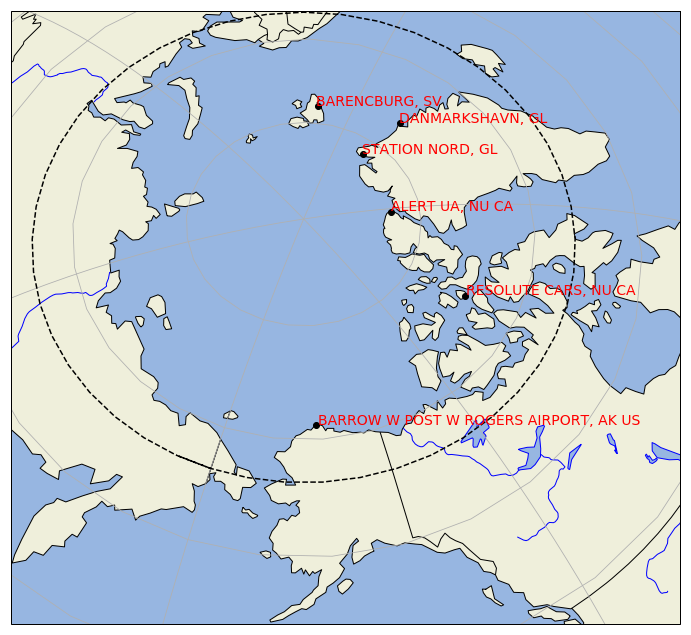

In [8]:
plt.figure(figsize=(12,12))
ax = plt.axes(projection=ccrs.Orthographic(-160, 60))

ax.add_feature(cartopy.feature.OCEAN, zorder=0)
ax.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black')
ax.add_feature(cartopy.feature.RIVERS, zorder=0, edgecolor='blue')
ax.add_feature(cartopy.feature.LAKES, zorder=0, edgecolor='blue')
ax.add_feature(cartopy.feature.BORDERS, zorder=0)
ax.gridlines()
ax.set_extent((-100,-190,50,120))
#ax.set_global()


# ax.scatter(barrow_lon,barrow_lat,color='red', marker='o',transform=ccrs.Geodetic(), zorder=2)
# ax.text(barrow_lon+.25,barrow_lat+0.25, 'Barrow',horizontalalignment='left',size=18,transform=ccrs.Geodetic())

for index, row in locations.iterrows():
    ax.scatter(row['LONGITUDE'],row['LATITUDE'],color='k', marker='o',transform=ccrs.Geodetic(), zorder=2)
    ax.text(row['LONGITUDE']+.5,row['LATITUDE'],row['NAME'],color='red',size=14,transform=ccrs.Geodetic())
    
# draw Arctic circle
ax.plot(list(range(180,-190,-8)),np.repeat(66.33,47),'k--',transform=ccrs.Geodetic())

In [9]:
yearly_avg = arctic.groupby(['STATION','NAME','year'])[['TMAX','TMIN','PRCP']].mean().reset_index()
year_obs = arctic.groupby(['STATION','year'])[['DATE']].count().reset_index()
year_obs.columns = ['STATION','year','obs']
yearly_avg = yearly_avg.merge(year_obs,on=['STATION','year'])
yearly_avg.head()

,STATION,NAME,year,TMAX,TMIN,PRCP,obs
0,CA002400306,"ALERT UA, NU CA",1950,NaN,NaN,0.035593,112
1,CA002400306,"ALERT UA, NU CA",1951,NaN,NaN,0.040522,365
2,CA002400306,"ALERT UA, NU CA",1952,NaN,NaN,0.033347,366
3,CA002400306,"ALERT UA, NU CA",1953,NaN,NaN,0.034818,365
4,CA002400306,"ALERT UA, NU CA",1957,13.127778,-0.423913,0.036667,189


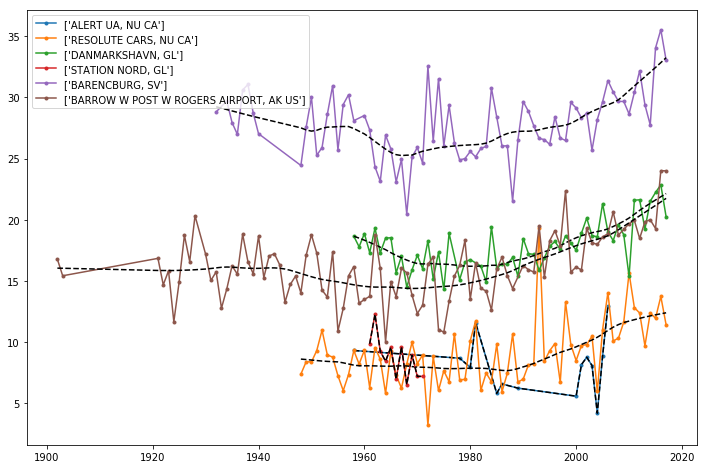

In [11]:
plt.figure(figsize=(12,8))

for st in yearly_avg['STATION'].drop_duplicates().tolist():
    st_avg = yearly_avg[yearly_avg['STATION']==st]
    st_avg = st_avg[st_avg['obs']>=360]
    plt.plot(st_avg['year'],st_avg['TMAX'],'.-',label=pd.unique(st_avg['NAME']))
    smoothed=lowess(st_avg['TMAX'],st_avg['year'],frac=1./4,return_sorted=False)
    plt.plot(st_avg['year'],smoothed,'k--')

plt.legend()

/Users/ChadMorgan/anaconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/ChadMorgan/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


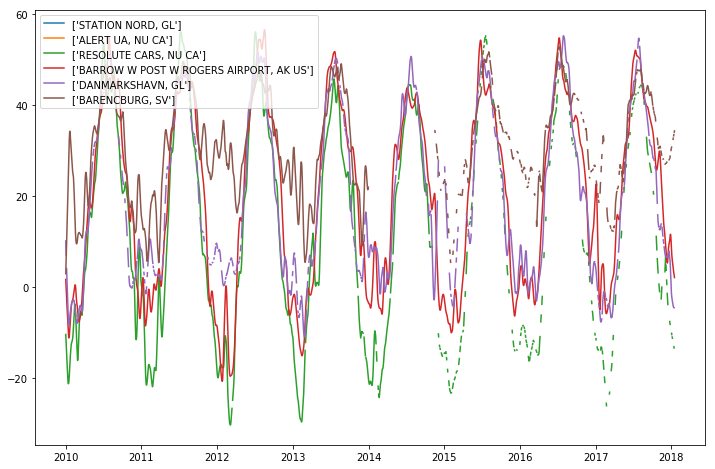

In [100]:
plt.figure(figsize=(12,8))

for st in arctic['STATION'].drop_duplicates().tolist():
    st_obs = arctic[arctic['STATION']==st]
    st_obs = st_obs[st_obs['year']>=2010]
#     plt.plot(st_obs['DATE'],st_obs['TMAX'],'o',label=pd.unique(st_obs['NAME']),alpha=.5)
    smoothed=lowess(st_obs['TMAX'],st_obs['daynr'],frac=1./100,return_sorted=False)
    plt.plot(st_obs['DATE'],smoothed,label=pd.unique(st_obs['NAME']))
    
plt.legend(loc='upper left')   